In [1]:
# mount drive and change directory to project folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/520 Final Project"

/content/drive/.shortcut-targets-by-id/1KHBlsdIi36o_ikonJZ-usBVzGPrZlH0V/520 Final Project


#loading data

In [3]:
import numpy as np
with open("X_train_spec_db.npy", 'rb') as f:
  X_train_spec = np.load(f)
with open("X_test_spec_db.npy", 'rb') as f:
  X_test_spec = np.load(f)
with open("y_train_spec.npy", 'rb') as f:
  y_train_spec = np.load(f)[:,40:85]
with open("y_test_spec.npy", 'rb') as f:
  y_test_spec = np.load(f)[:,40:85]

In [4]:
X_train_spec.shape, y_train_spec.shape, X_test_spec.shape, y_test_spec.shape

((326580, 84, 32), (326580, 45), (3981, 84, 32), (3981, 45))

In [5]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

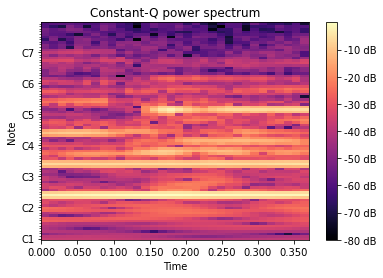

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(X_train_spec[7],
                               sr=44100, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()
print(y_train_spec[7])

In [6]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt

In [7]:
#needs to take a 84 x 32 and get a 45
class Logistic(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_1 = torch.nn.Linear(84 * 32, 45)
  def forward(self, x):
      x = x.reshape((x.size(0), -1))
      x = self.linear_1(x)
      return x

In [8]:
#put data into trainloader
trainset = []
for i in range(len(X_train_spec)):
  trainset.append([X_train_spec[i], y_train_spec[i]])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [9]:
epochs = 10
model = Logistic()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5) 
train_loss = []
# training iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (audio, label) in enumerate(trainloader):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(audio)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 1, loss: 6231.4912
epoch: 2, loss: 4568.2191
epoch: 3, loss: 4192.0507
epoch: 4, loss: 3960.5705
epoch: 5, loss: 3793.0344
epoch: 6, loss: 3664.2759
epoch: 7, loss: 3558.1957
epoch: 8, loss: 3468.1936
epoch: 9, loss: 3396.8851
epoch: 10, loss: 3333.5936


In [10]:
torch.save(model.state_dict(), 'LogisticafterQTransform.pt')

In [ ]:
with torch.no_grad():
  X = torch.tensor(X_train_spec).float()
  preds = model(X)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracies = []
recalls = []
precisions = []
for i in range(45):
  accuracies += [accuracy_score((preds.numpy()[:,i] > 0), y_train_spec[:,i])]
  recalls += [recall_score((preds.numpy()[:,i] > 0), y_train_spec[:,i], zero_division=0)]
  precisions += [precision_score((preds.numpy()[:,i] > 0), y_train_spec[:,i], zero_division=0)]

In [ ]:
print(accuracies)
print(recalls)
print(precisions)

[0.9813032028905628, 0.9772276318206872, 0.9846775675179129, 0.9671841508971768, 0.9762110355808684, 0.9646457223344969, 0.9668595749892829, 0.9707085553310062, 0.9488547982117704, 0.9703686692387776, 0.9481229714005757, 0.9413711801090086, 0.9521954804335844, 0.9450823687917203, 0.9653744871088248, 0.9205248331189908, 0.946901218690673, 0.9298426113050401, 0.9346040786331068, 0.9420815726621349, 0.910178210545655, 0.9510717129034234, 0.9176710147590177, 0.9356574193153285, 0.9281952354706351, 0.925944638373446, 0.9505848490415825, 0.9136383122052789, 0.9456427215383674, 0.9166881009247352, 0.9479361871516933, 0.9490140241288505, 0.9304213362728887, 0.9582981199093638, 0.9372649886704636, 0.9538796007103926, 0.9458784983771205, 0.9526731581848246, 0.9686294322983648, 0.9487078204421582, 0.9715934839855472, 0.9622940780206993, 0.9757088615346928, 0.9768111948067855, 0.9719793006307796]
[0.6107951107346, 0.7794548321694075, 0.7984705353126406, 0.6770894643908181, 0.6564511741771692, 0.81

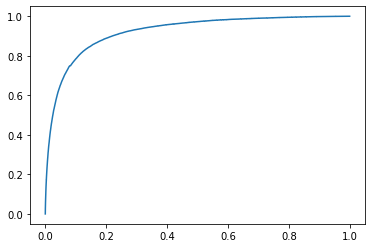

In [ ]:
# ROC curve for middle C: MIDI 60, so index 60-40=20
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_spec[:,20], preds[:,20])
plt.plot(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.9218755086375258


In [ ]:
# get the average AUC over all the notes
aucs = []
for i in range(45):
  fpr, tpr, _ = roc_curve(y_train_spec[:,i], preds[:,i])
  aucs += [auc(fpr,tpr)]
print(np.mean(aucs))

0.9271392529863741


In [11]:
with torch.no_grad():
  X = torch.tensor(X_test_spec).float()
  preds = model(X)

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracies = []
recalls = []
precisions = []
for i in range(45):
  accuracies += [accuracy_score((preds.numpy()[:,i] > 0), y_test_spec[:,i])]
  recalls += [recall_score((preds.numpy()[:,i] > 0), y_test_spec[:,i], zero_division=0)]
  precisions += [precision_score((preds.numpy()[:,i] > 0), y_test_spec[:,i], zero_division=0)]

In [14]:
print(accuracies) #mean: 95.9
print(recalls) #mean: 70.21
print(precisions) #mean: 39.27

[0.9902034664657121, 0.9839236372770661, 0.9894498869630746, 0.9778950012559658, 0.9741271037427782, 0.97764380808842, 0.9593067068575735, 0.9806581260989701, 0.9653353428786737, 0.9889475006279829, 0.9469982416478272, 0.9389600602863603, 0.9738759105752324, 0.9645817633760362, 0.9643305702084903, 0.9158502888721427, 0.948756593820648, 0.9583019341873901, 0.9118311981914092, 0.9623210248681235, 0.9510173323285607, 0.9590555136900276, 0.9309218789248932, 0.9274051745792514, 0.9432303441346396, 0.8749058025621703, 0.9532780708364732, 0.9176086410449635, 0.9447375031399146, 0.942476764632002, 0.9469982416478272, 0.9590555136900276, 0.9603114795277569, 0.9605626726953027, 0.9178598342125094, 0.9449886963074604, 0.9560411956794775, 0.9577995478522984, 0.968098467721678, 0.9409696056267269, 0.97764380808842, 0.9726199447375031, 0.9859331826174328, 0.9854307962823411, 0.987189148455162]
[0.6415094339622641, 0.5555555555555556, 0.6285714285714286, 0.7936507936507936, 0.7843137254901961, 0.7788

In [15]:
print(np.mean(recalls))
print(np.mean(precisions))

0.6313233777272483
0.41655991185959335


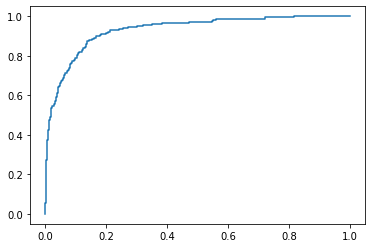

In [16]:
# ROC curve for middle C: MIDI 60, so index 20
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_spec[:,20], preds[:,20])
plt.plot(fpr, tpr)
plt.show()

In [17]:
import pickle
with open('logistic_fpr.npy', 'wb') as f:
  np.save(f, fpr, allow_pickle=True)
with open('logistic_tpr.npy', 'wb') as f:
  np.save(f, tpr, allow_pickle=True)

In [18]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.9305437766360831


In [19]:
# get the average AUC over all the notes
aucs = []
for i in range(45):
  fpr, tpr, _ = roc_curve(y_test_spec[:,i], preds[:,i])
  aucs += [auc(fpr,tpr)]
print(np.mean(aucs))

0.9170231105018576


Results: 

With 5 training epochs, lr=1e-3, get train AUC of 0.8805318266265569 and test AUC of 0.8893701334073891. Suggests no overfitting yet.

With 10 training epochs, get no improvement

With 10 epochs, lr=1e-4, get very similar.

With 30 epochs, lr=1e-3, get slightly worse results all around.

Moral: logistic trains fast.

Next, inputting everything in decibels:
With 5 epochs, lr=1e-4 (1e-3 causing instability), get immediate improvement with middle C AUC 0.9265276694829263 on test set and 0.9128363207795586

New metric: average AUC over all the notes: here on training set 0.9225969124493683 and on test set 0.9271160205923473 (so middle C actually slightly worse than average!)

With 30 epochs and lr=1e-5: slight improvement with average test AUC 0.9291533053495106